In [6]:
from matplotlib import pyplot as plt
import pandas as pd
import scipy.io
%matplotlib inline
plt.style.use('ggplot')

## Data

In [107]:
data = scipy.io.loadmat('ex8data1.mat')
X = data['X']
# cross-validation set
Xval = data['Xval']
yval = data['yval'].flatten()
print X.shape, Xval.shape, yval.shape

(307, 2) (307, 2) (307,)


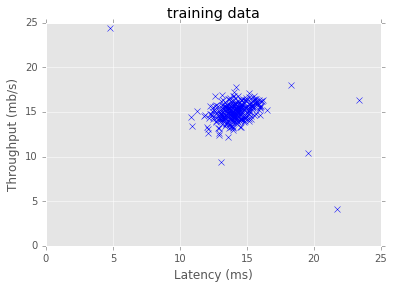

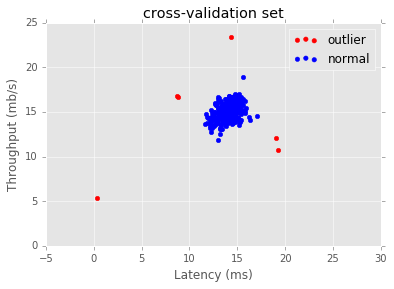

In [119]:
plt.plot(X[:, 0], X[:, 1], 'bx')
plt.title("training data")
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.figure()
anomaly = Xval[yval==1]
normal = Xval[yval==0]
plt.scatter(anomaly[:,0],anomaly[:,1], color='r')
plt.scatter(normal[:,0],normal[:,1], color='b')
plt.title("cross-validation set")
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.legend(('outlier','normal'))

## Gaussian parameter estimation

In [36]:
def estimate_gaussian(X):
    mean = [None]*len(X[0])
    var = [None]*len(X[0])

    for j in range(len(X[0])):
        s = 0
        for i in range(len(X)):
            s += X[i][j]
        s = s/float(len(X))
        mean[j] = s
        
    for j in range(len(X[0])):
        s = 0
        for i in range(len(X)):
            s += (X[i][j] - mean[j])**2
        s = s/float(len(X))
        var[j] = s
    return [mean,var]

print "mine:", estimate_gaussian([[4,5],[2,4]])
print "np:", np.mean([[4,5],[2,4]],axis=0), np.var([[4,5],[2,4]],axis=0)

mine: [[3.0, 4.5], [1.0, 0.25]]
np: [ 3.   4.5] [ 1.    0.25]


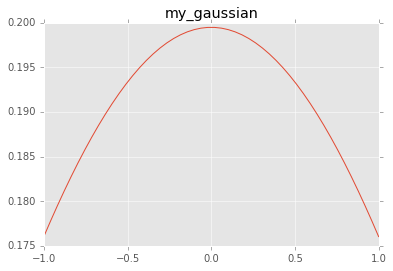

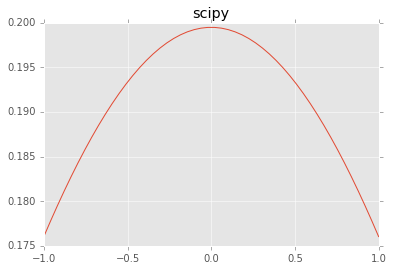

In [53]:
from scipy.stats import norm
def my_gaussian(x,u,sigma2):
    return (1/np.sqrt(2*np.pi*sigma2)) * np.exp(-((x-u)**2)/(2*sigma2))

x = np.linspace(-1,1)
plt.title("my_gaussian")
plt.plot(x,my_gaussian(x,0,2**2))
plt.figure()
plt.title("scipy")
plt.plot(x,norm(loc=0,scale=2).pdf(x))

In [110]:
mean, sigma2 = estimate_gaussian(X)
# print np.mean(X,axis=0), np.var(X,axis=0)
print mean, sigma2

[14.1122257839456, 14.99771050813621] [1.8326314134945172, 1.7097453308287784]


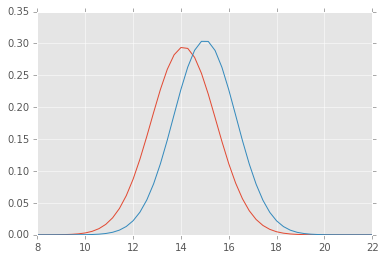

In [70]:
gauss1 = scipy.stats.norm(mean[0],np.sqrt(sigma2[0]))
gauss2 = scipy.stats.norm(mean[1],np.sqrt(sigma2[1]))
x = np.linspace(8,22)
plt.plot(x, gauss1.pdf(x))
plt.plot(x, gauss2.pdf(x))

## Multivariate gaussian

In [111]:
def multivariate_gaussian(X, mu, Sigma2):
    k = len(mu)
    Sigma2 = np.diag(Sigma2)
    X = X - mu
    p = (2 * np.pi) ** (- k / 2) * np.linalg.det(Sigma2) ** (-0.5) * \
        np.exp(-0.5 * np.sum(X.dot(np.linalg.pinv(Sigma2))*X, axis=1))

    return p

p = multivariate_gaussian(X,mean,sigma2)
x = np.linspace(8,22)
q = scipy.stats.multivariate_normal.pdf(X,mean=mean,cov=np.diag(sigma2))
print p.shape,q.shape

(307,) (307,)


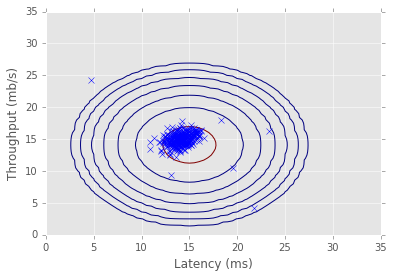

In [113]:
def visualize_fit(X, mu, sigma2):
    n = np.linspace(0,35,71)
    X1 = np.meshgrid(n,n)
    Z = multivariate_gaussian(np.column_stack((X1[0].T.flatten(), X1[1].T.flatten())),mu,sigma2)
#    Z = scipy.stats.multivariate_normal.pdf(np.column_stack((X1[0].T.flatten(), X1[1].T.flatten())),mean=mu,cov=np.diag(sigma2))
    Z = Z.reshape(X1[0].shape)

    plt.plot(X[:, 0], X[:, 1],'bx')
    # Do not plot if there are infinities
    if not np.isinf(np.sum(Z)):
        plt.contour(X1[0], X1[1], Z, 10.0**np.arange(-20, 0, 3).T)

visualize_fit(X,mean,sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')

## Estimate best epsilon threshold on cross-validation set

In [122]:
pval = multivariate_gaussian(Xval, mean, sigma2)

In [138]:
def selectThreshold(yval, pval):
    bestEpsilon = 0
    bestF1 = 0

    stepsize = (np.max(pval) - np.min(pval)) / 1000.0
    for epsilon in np.arange(np.min(pval),np.max(pval), stepsize):

        predictions = (pval < epsilon)

        tp = sum(np.logical_and(yval==1, predictions==1))
        fp = sum(np.logical_and(yval==1, predictions==0))
        tn = sum(np.logical_and(yval==0, predictions==0))
        fn = sum(np.logical_and(yval==0, predictions==1))
        # np.divide for div by 0
        precision = np.divide(float(tp),(tp+fp))
        recall = np.divide(float(tp),(tp+fn))
        F1 = 2*precision*recall/(precision+recall)

        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

epsilon, F1 = selectThreshold(yval, pval)
print 'Best epsilon found using cross-validation: %e' % epsilon
print 'Best F1 on Cross Validation Set:  %f' % F1

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set:  0.875000


## Visualize outliers

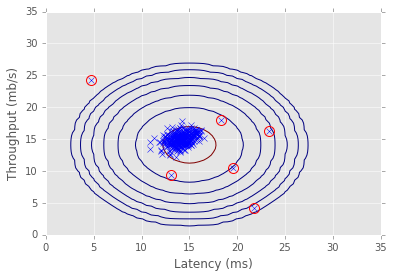

In [141]:
outliers = np.where(p < epsilon, True, False)
visualize_fit(X,mean,sigma2)
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(X[outliers, 0], X[outliers, 1], 'ro', lw=2, markersize=10, fillstyle='none', markeredgewidth=1)